# Introduction
In this tutorial, we present fault attack software countermeasures and verify their effectiveness in a simulation of a 32-bit SPARC processor called LEON3. First, faults are injected during the execution of an unprotected implementation for a given number of runs and outputs of the program are observed for each run in order to classify them into faulty behaviours such as *incorrect output*, *no output* and *processor crashed*. Then, a countermeasure is added to the program and it is shown that the count of faulty outputs decreases in case of a correction-based countermeasure and fault gets detected in case of detection-based countermeasure, thereby, proving that adding a given countermeasure provides resistance to the design against faults. 

To inject faults and determine the classification of faulty outputs, a wrapper program for Gaisler’s TSIM LEON3 CPU simulator is written in Python. The wrapper enables us to use TSIM commands to inject faults into any instruction, memory location, or register during the execution of the code.

We will start by stating the requirements, then compilation process, golden-run execution and lastly about fault simulation framework to run experiments for fault injection attacks and countermeasures.

## Requirements

<ul>
<li> TSIM, an instruction-level simulator capable of emulating LEON3 systems </li>
<li> BCC2, Bare-C Cross-Compiler System for LEON3 processors</li>
</ul>

---
- Download *bcc-2.2.0-gcc-linux64.tar.xz* from [Link to BCC2](https://www.gaisler.com/anonftp/bcc2/bin/)
- Run `tar -xJf bcc-2.2.0-gcc-linux64.tar.xz -C /opt/` in the terminal. This will create *bcc-2.2.0-gcc* folder  under `/opt/` 
- Add `export PATH=/opt/bcc/bcc-2.2.0-gcc/bin/:$PATH` to the *.bashrc* file in the home directory 

**Note:** Github repo already contains the TSIM binary for Linux under `FIA_Demos/software/tsim-eval/tsim/linux-x64` directory path.

## Compilation

Source Code for original program without countermeasure and when implemented with a given countermeasure can be found under the folder named as `$countermeasure name$_cm` at `FIA_Demos/src/` location. Let us consider the compilation of *checksum* countermeasure code under the folder named as *checksum_cm* at `FIA_Demos/src/` location:

**To Compile, run:**
- `cd FIA_Demos/src/checksum_cm` 
- `make` This will generate two executable and their corresponding diassembly files for program without and with checksum countermeasure under `/elf` folder created by the makefile at current location.
- `clean all` This will remove all the generated files under `/elf` folder.

Similarly, code for other countermeasures are located under the folder names tagged with their countermeasure name at `FIA_Demos/src/` location and each folder has its own makefile to do the compilation.

## Fault Injection Attack (FIA) Simulation  

In this section, we give an overview of the simulation-based fault injection environment we use to inject faults into a target application running on a TSIM-LEON3 simulator. 

FIA simulation framework injects faults according to a selected fault model at a required time and location into the test program execution and keeps track of faulty outputs for each program execution, detected by comparing the observed output with the expected output. The goal is to generate faulty outputs according to a set of state-of-the-art ISA fault models and the test program. Then, the test program is hardened with a countermeasure at program level designed with respect to a given fault model specifying the type of faults FIA simulation carried out.

A fault model is an abstraction of the consequences of physical attacks and modeling them at the desired level (architectural level, assembly code level, source code level). Consequences of fault attacks, at program level, includes the corrupted variable value loaded from memory, modified program control flow or a corrupted program as a result of instructions manipulation.

The fault attack simulation is performed by running: <br>
`import papermill as pm` <br>
`pm.execute_notebook(in_nb, out_nb, parameters = param_dict, log_output = True)`

where, **execute_notebook()** is a function from **papermill** library which is used to execute a source notebook **in_nb** when passed a dictionary of parameters **param_dict** and saves the output in a destination notebook **out_nb**. **in_nb** internally executes the fault injection simulation script, **faultinj.py**, which uses TSIM commands to inject faults into the data in RAM, the data exchanged through data/instruction buses or the code executed by the processor. Both these notebooks, **in_nb** and **out_nb**, and, **faultinj.py** are located at `FIA_Demos/software/fia_framework` path.


**param_dict** is used to pass fault injection parameters to the framework which are described as follows:
- **fault_count:** number of consecutive faults to inject (default = 1)
- **bit_flips:** number of random bit flips to inject (default = 1)
- **consecutive_flips:** number of bits to flip consecutively in a data word (default = 1)
- **skips:** number of instructions to skip per fault injection (default = 0)
- **instr_modify:** perform an instruction replacement per fault injection if value is 1 (default = 0)
- **iterations:** iterations to repeat simulation (default = 1)
- **data:** data to XOR for induced fault error (0 means random bit flip) (default = 0)
- **verbose:** True if logging of output is required (default = True)
- **binary:** the compiled program to simulate
- **correct_output:** the correct output to expect from program
- **byte:** Inject the bit flips confined to a random byte in word  (default = False)
- **start:** starting address or label to exclusively start injecting faults (default = main)
- **end:** ending address or label to inclusively end injecting faults (default = 0x40001294)

**Note:** The default values are used for fault injection if **param_dict** is not passed to the parameters argument of execute_notebook() function. 

The FIA simulation framework supports the four most commonly used **fault models** mentioned in literature:
- **Bit flip:** This fault model is enabled by setting **bit_flips** parameter to a non-zero value. The simulator injects random single (**bit_flips** = 1) and multiple (1 < **bit_flips** <= 32) bit flips in the destination register of an instruction. This fault model is also referred to as **Random register corruption** fault model which includes corruption of a general-purpose register except a stack pointer (%sp) and frame pointer (%fp). 
- **Random byte fault:** This fault model is enabled by setting **bit_flips** and **byte** parameters to a non-zero value and True respectively. The simulator randomly affects a single byte of the 32-bit data by injecting single or multiple bit flip.
- **Instruction skip:** This fault model is enabled by setting **skips** parameter to a non-zero value. The simulator injects both single and multiple consecutive instruction skips. It is a special case of instruction replacement fault model where opcode of an instruction is changed with a **nop** instruction. This fault model depends on ISA and instruction encoding to do a specific instruction replacement.
- **Instruction replacement:** This fault model is enabled by setting **instr_modify** and **bit_flips** parameters to one and a non-zero value respectively. The simulator sets a bit flip model on the opcode that changes one instruction to a different one leading to control-flow fault attacks. Again, this can be either single or multiple bit flip. 

**Classification of outcome of FIA simulation:**
- **Correct output:** Experiments produce results which are bit-wise identical to those produced by the corresponding fault-free execution.
- **Incorrect output:** Experiments produce results that are not bit-wise identical to those of the fault-free execution.
- **No output:** Experiments in which no output is generated. 
- **Processor crashed:** Experiments which fail to successfully terminate.


## Golden-run Execution

The purpose of this step is to gather information on the behavior of the fault-free target application. This will provide us an input to **correct_output** parameter discussed in [Fault Injection Attack (FIA) Simulation](#Fault-Injection-Attack-(FIA)-Simulation). Let us take an example of fault-free execution of source code *test1.c* at `FIA_Demos/src/checksum_cm/` location. We will compile the code by following the steps given in [Compilation](#Compilation).

**To execute directly using TSIM-LEON3, run:**
- `cd FIA_Demos/software/tsim-eval/tsim/linux-x64/` 
- `./tsim-leon3 ../../../../src/checksum_cm/elf/test1.elf` This will start tsim and load test1.elf 
- Execute `run` command in tsim>
- To exit from TSIM, execute `quit` command in tsim>

    
We get output of the program as `{Value of y = 15}` which is as expected as shown in the figure below: 


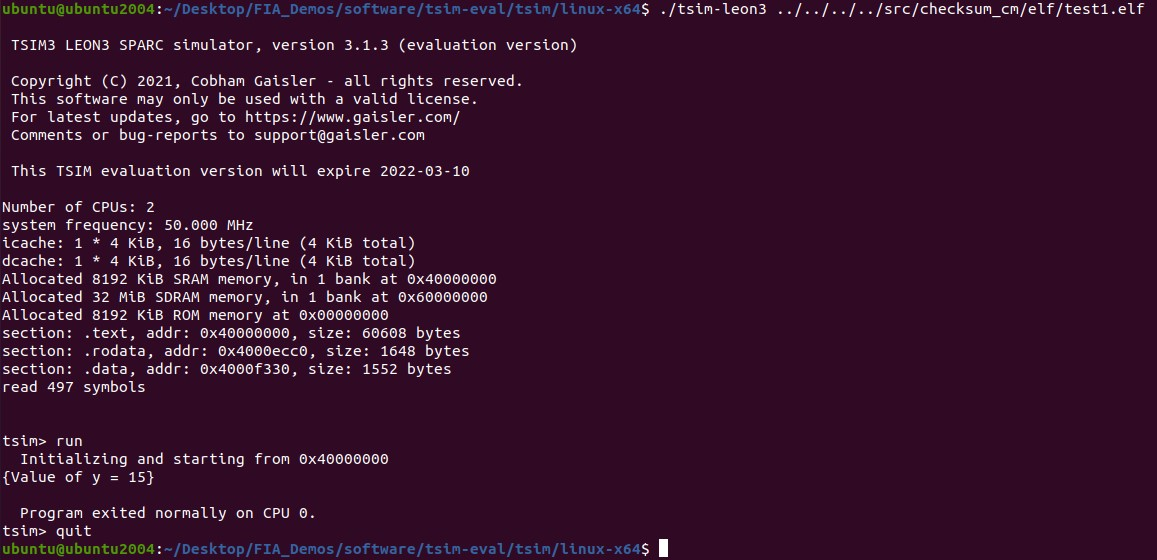

**Note:** The parameter **correct_output** will be set to `Value of y = 15` instead of `{Value of y = 15}` in case of fault injection simulation of test1.c program. The reason is that fault injection simulation script extracts the program output substring enclosed within {} from TSIM output by searching for a regular expression pattern {.\*?} in TSIM output and then compares this substring with the **correct_output** value in order to classify the faulty output.   


## Next Steps

Now, that we have learned about how to perform compilation, golden-run execution and configure various fault injection parameters of the FIA simulation framework to inject faults to any target application execution. 
<br> We next study fault injection experiments for each type of fault model and present countermeasures for them. Please navigate to the other notebooks in `FIA_Demos/tutorials/` folder to understand fault attack software countermeasures.

## References

1. A. Barenghi, L. Breveglieri, I. Koren and D. Naccache, "Fault Injection Attacks on Cryptographic Devices: Theory, Practice, and Countermeasures," in Proceedings of the IEEE, vol. 100, no. 11, pp. 3056-3076, Nov. 2012, doi: 10.1109/JPROC.2012.2188769.